In [ ]:
import cv2
import numpy as np
import glob
import json
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import sys
import time
import random
random.seed(time.time())

sys.path.append(os.path.dirname(os.path.abspath('.')))
import utils.frame_slicing as frame_slicing
import utils.frame_concatent as frame_concatent

number_of_squares_x = 11
number_of_internal_corners_x = number_of_squares_x - 1
number_of_squares_y = 8
number_of_internal_corners_y = number_of_squares_y - 1
SQUARE_SIZE = 0.023 # in meters
cameras = ['cam2', 'cam3', 'wide', 'cam0', 'cam1']

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(10,9,0)
objp = np.zeros((number_of_internal_corners_x * number_of_internal_corners_y,3), np.float32)
objp[:,:2] = np.mgrid[0:number_of_internal_corners_x,0:number_of_internal_corners_y].T.reshape(-1,2)
objp = objp * SQUARE_SIZE

# Get image points
This function is used to get the image points of the chessboard. So the results can be reused during intrinsic calibration and extrinsic calibration.

Parameters:  
    None  
Return:  
    rets: array of boolean values, True if the chessboard is found, False otherwise shape (number of cameras, number of frames)  
    objpoints: array of image points shape (number of frames, number of cameras, number_of_internal_corners_x * number_of_internal_corners_y, 2)  
    shape: tuple of the shape of the image

# Project arrows into the image

# Pipeline-Intrinsic

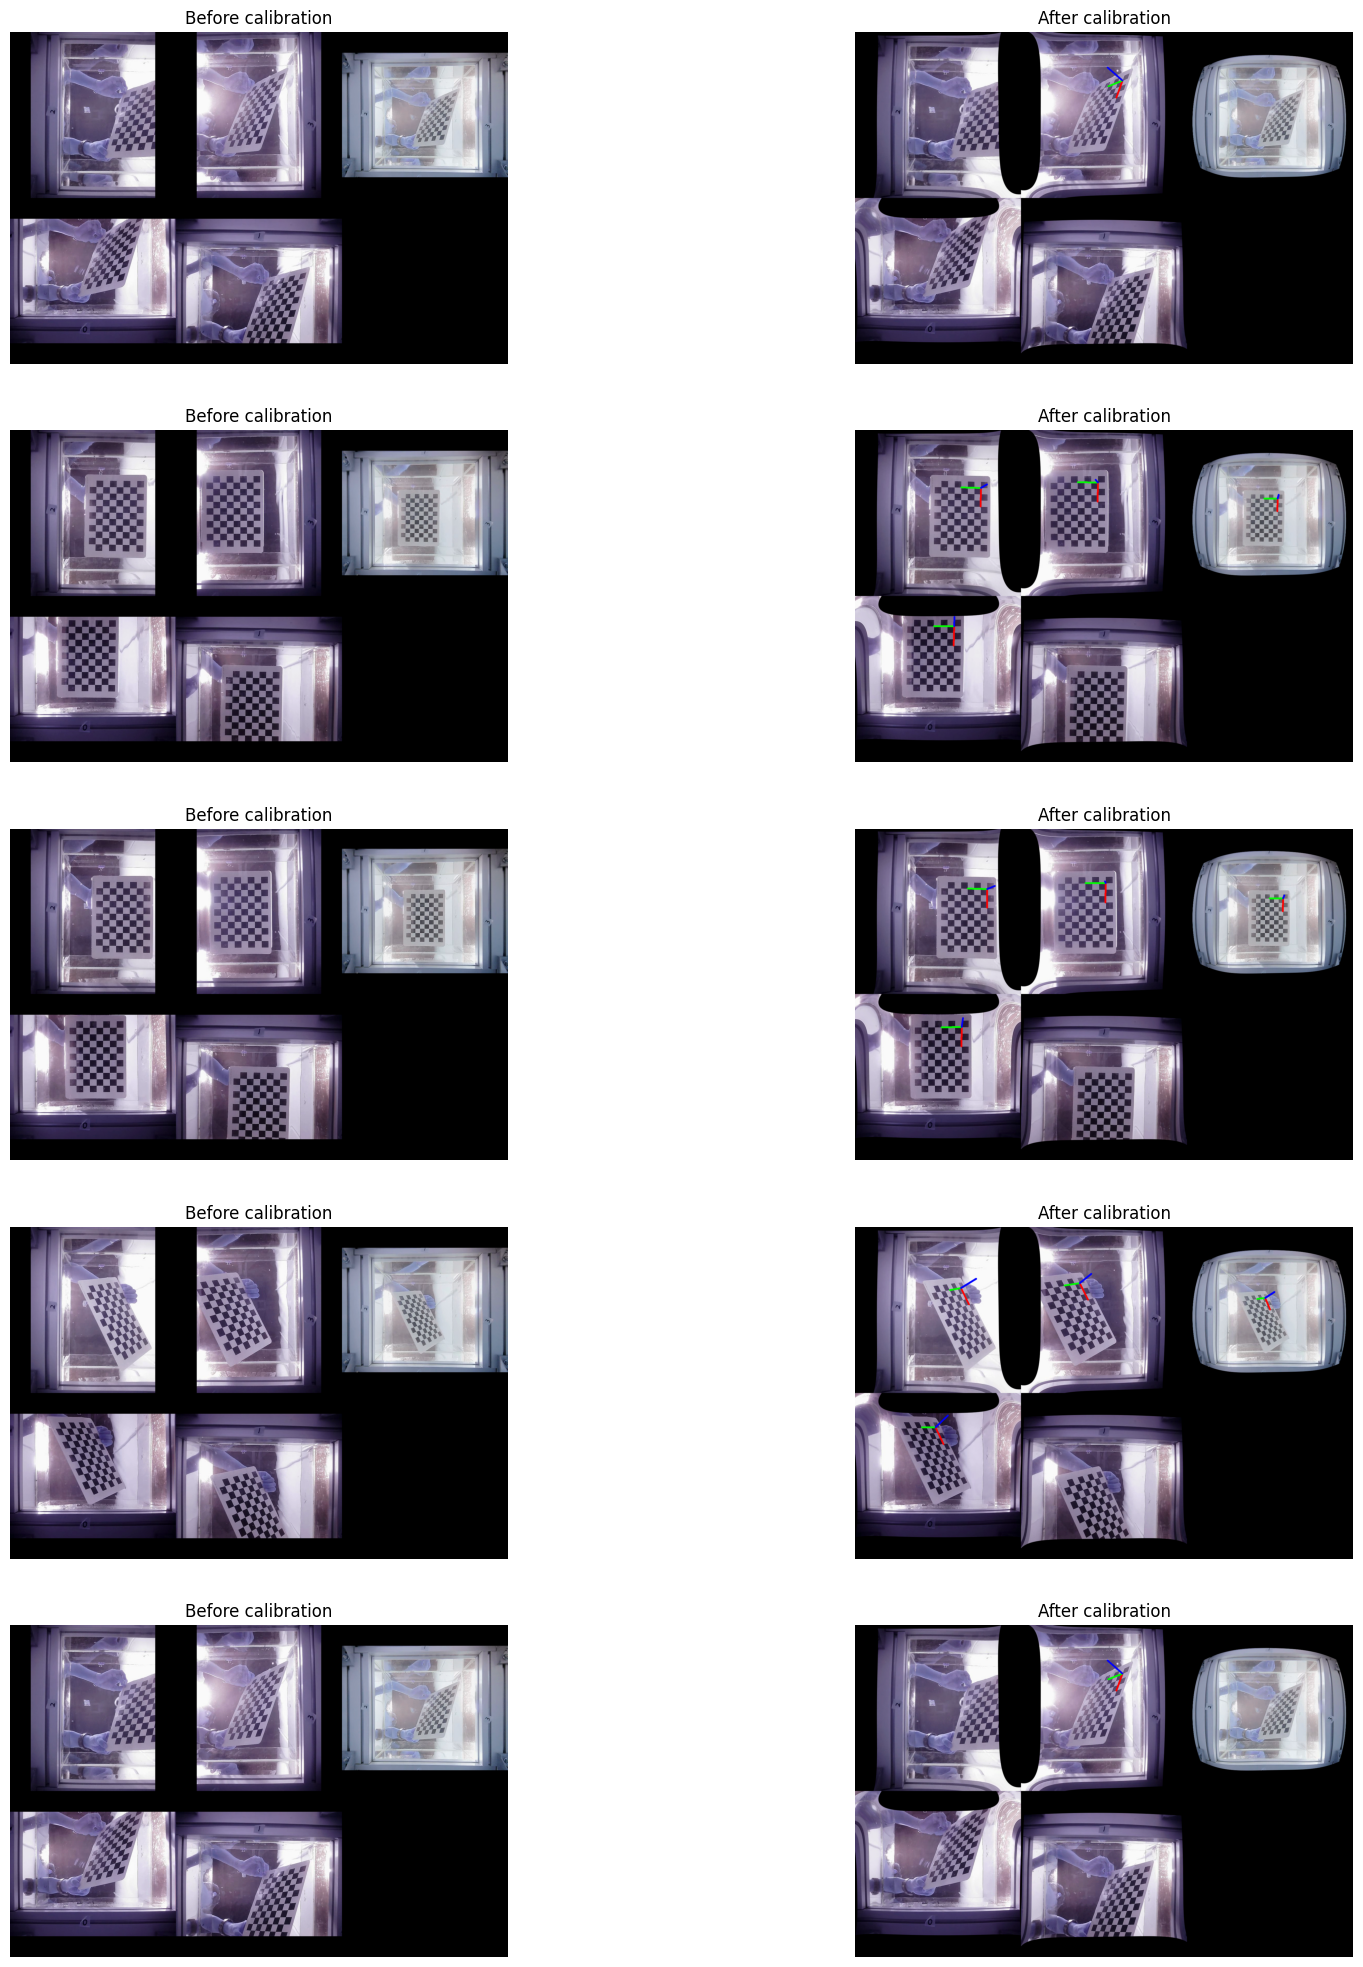

# Extrinsic calibration

### Transformation Matrix

$$ H = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} 
    = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

In [7]:
def extrinsic_calibration():
    with open('results/rets.json', 'r') as f:
        rets = np.array(json.load(f))
    with open('results/object_points.json', 'r') as f:
        objpoints = np.array(json.load(f))
    with open('results/image_points.json', 'r') as f:
        imgpoints = np.array(json.load(f))
    with open('results/shape.json', 'r') as f:
        shape = tuple(json.load(f))
    mtxs = {}
    dists = {}
    for camera_name in cameras:
        with open(f'results/intrinsic_{camera_name}.json', 'r') as f:
            data = json.load(f)
            mtx = np.array(data['mtx'])
            dist = np.array(data['dist'])
            mtxs[camera_name] = mtx
            dists[camera_name] = dist
    
    for camera_name in cameras:
        transformation_matrix = np.eye(4)
        if camera_name == 'wide':
            pass
        else:
            stereo_objpoints = []
            stereo_imgpoints1 = []
            stereo_imgpoints2 = []
            for i in range(len(objpoints)):
                if rets[i, cameras.index(camera_name)] and rets[i, cameras.index('wide')]:
                    stereo_objpoints.append(objpoints[i, cameras.index(camera_name), :, :].astype(np.float32))
                    stereo_imgpoints1.append(imgpoints[i, cameras.index(camera_name), :, :].astype(np.float32))
                    stereo_imgpoints2.append(imgpoints[i, cameras.index('wide'), :, :].astype(np.float32))
            stereo_objpoints = np.array(stereo_objpoints)
            stereo_imgpoints1 = np.array(stereo_imgpoints1)
            stereo_imgpoints2 = np.array(stereo_imgpoints2)
            
            flags = (cv2.CALIB_FIX_INTRINSIC)
            results = cv2.stereoCalibrate(objectPoints=stereo_objpoints, imagePoints1=stereo_imgpoints1, imagePoints2=stereo_imgpoints2,
                                        cameraMatrix1=mtxs[camera_name], distCoeffs1=dists[camera_name], cameraMatrix2=mtxs['wide'], 
                                        distCoeffs2=dists['wide'], imageSize=shape, 
                                        flags=flags)
            R = results[5]
            T = results[6]
            transformation_matrix[:3, :3] = R
            transformation_matrix[:3, 3] = T[:3, 0]
        
        print(f'{camera_name} has {len(stereo_objpoints)} successful images')
        print(f'{camera_name} transformation matrix: {transformation_matrix}')
        
        with open(f'results/extrinsic_{camera_name}.json', 'w') as f:
            json.dump(transformation_matrix.tolist(), f)
    

In [8]:
def visualize(fig, elev, azim, roll, i):
    transformation_matrices = {}
    for camera_name in cameras:
        with open(f'results/extrinsic_{camera_name}.json', 'r') as f:
            transformation_matrix = np.array(json.load(f))
            transformation_matrices[camera_name] = transformation_matrix
            
    ax = fig.add_subplot(2, 3, i, projection='3d', elev=elev, azim=azim, roll=roll)
    length = 0.5
    width = 0.5
    height = 0.5
    
    x = [-length/2, length/2, length/2, -length/2]
    y = [-width/2, -width/2, width/2, width/2]
    for i in range(4):
        ax.plot([x[i], x[i]], [y[i], y[i]], [0, height], 'b-')
        
    x = [-length/2, length/2, length/2, -length/2]
    z = [0, 0, height, height]
    for i in range(4):
        ax.plot([x[i], x[i]], [-width/2, width/2], [z[i], z[i]], 'b-')
        
    y = [-length/2, length/2, length/2, -length/2]
    z = [0, 0, height, height]
    for i in range(4):
        ax.plot([-length/2, length/2], [y[i], y[i]], [z[i], z[i]], 'b-')
    
    for camera_name in cameras:
        colors = ['red', 'green', 'blue']
        axis = np.eye(3) * SQUARE_SIZE
        for i in range(3):
            orientation = transformation_matrices[camera_name][:3, :3] @ axis[i, :]
            x = transformation_matrices[camera_name][0, 3]
            y = transformation_matrices[camera_name][1, 3]
            z = transformation_matrices[camera_name][2, 3]
            u = orientation[0]
            v = orientation[1]
            w = orientation[2]
            ax.quiver(x, y, z, u, v, w, color = colors[i], length=1)
            
            if i == 0:
                ax.text(x, y, z, camera_name, color = 'black')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

### Projection Matrix

$$  Extrinsic_{camera}\cdot Transformation_{wide} \cdot \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} =  Transformation_{camera} \cdot \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
$$

In [43]:
def chessboard_projection():
    mtxs = {}
    dists = {}
    transformation_matrices = {}
    for camera_name in cameras:
        with open(f'results/intrinsic_{camera_name}.json', 'r') as f:
            data = json.load(f)
            mtx = np.array(data['mtx'])
            dist = np.array(data['dist'])
            mtxs[camera_name] = mtx
            dists[camera_name] = dist
        with open(f'results/extrinsic_{camera_name}.json', 'r') as f:
            transformation_matrix = np.array(json.load(f))
            transformation_matrices[camera_name] = transformation_matrix
            
    i = 1
    colors = ['red', 'green', 'blue', 'yellow', 'purple']

    for camera_name in cameras:
        images = os.listdir('screen_shots')
        if camera_name == 'wide':
            continue
        while True:
            random_index = random.randint(0, len(images) - 1)
            frame = cv2.imread(f'screen_shots/{images[random_index]}')
            frames = frame_slicing.slicing_frame(frame)
            wide_img = frames[cameras.index('wide')]
            cam_img = frames[cameras.index(camera_name)]
            
            gray_wide = cv2.cvtColor(wide_img, cv2.COLOR_BGR2GRAY)
            gray_cam = cv2.cvtColor(cam_img, cv2.COLOR_BGR2GRAY)
            ret_wide, corners_wide = cv2.findChessboardCorners(gray_wide, (number_of_internal_corners_x, number_of_internal_corners_y), None)
            ret_cam, corners_cam = cv2.findChessboardCorners(gray_cam, (number_of_internal_corners_x, number_of_internal_corners_y), None)
            if ret_wide == True and ret_cam == True:
                img_points_wide = cv2.cornerSubPix(gray_wide, corners_wide, (11,11), (-1,-1), criteria=criteria)
                img_points_cam = cv2.cornerSubPix(gray_cam, corners_cam, (11,11), (-1,-1), criteria=criteria)
                cv2.drawChessboardCorners(gray_wide, (number_of_internal_corners_x,number_of_internal_corners_y), corners_wide, ret_wide)
                cv2.drawChessboardCorners(gray_cam, (number_of_internal_corners_x,number_of_internal_corners_y), corners_cam, ret_cam)
                plt.imshow(gray_wide, cmap='gray')
                plt.show()
                plt.imshow(gray_cam, cmap='gray')
                plt.show()
                cv2.drawChessboardCorners(gray_cam, (number_of_internal_corners_x,number_of_internal_corners_y), corners_cam, ret_cam)
                ret_wide,rvecs_wide, tvecs_wide = cv2.solvePnP(objp, img_points_wide, mtxs[camera_name], dists[camera_name])
                ret_cam,rvecs_cam, tvecs_cam = cv2.solvePnP(objp, img_points_cam, mtxs[camera_name], dists[camera_name])
                if ret_wide == True and ret_cam == True:
                    fig = plt.figure(figsize=(16, 24))
                    ax = fig.add_subplot(3, 2, i, projection='3d')
                    transformation_matrix_wide = np.eye(4)
                    R_cam, _ = cv2.Rodrigues(rvecs_cam)
                    R_wide, _ = cv2.Rodrigues(rvecs_wide)
                    transformation_matrix_wide[:3, :3] = R_wide
                    transformation_matrix_wide[:3, 3] = tvecs_wide.reshape(3)
                    transformation_matrix_cam = np.eye(4)
                    transformation_matrix_cam[:3, :3] = R_cam
                    transformation_matrix_cam[:3, 3] = tvecs_cam.reshape(3)
                    objp_homogeneous = np.concatenate((objp, np.ones((objp.shape[0], 1))), axis=1)
                    coord_thru_cam = transformation_matrix_cam @ objp_homogeneous.T
                    coord_thru_wide = transformation_matrix_wide @ objp_homogeneous.T
                    projected_coord = transformation_matrices[camera_name] @ coord_thru_cam
                    RMS_error = np.sqrt(np.mean(np.sum((projected_coord[:3, :] - coord_thru_wide[:3, :])**2, axis=0)))
                    space_between_points_cam = np.sqrt((coord_thru_cam[:3, :].T - coord_thru_cam[:3, 0])**2)
                    space_between_points_wide = np.sqrt((coord_thru_wide[:3, :].T - coord_thru_wide[:3, 0])**2)
                    print(space_between_points_cam - space_between_points_wide)
                    print(RMS_error)
                    ax.scatter(coord_thru_cam[0, :], coord_thru_cam[1, :], coord_thru_cam[2, :], color=colors[cameras.index(camera_name)])
                    ax.scatter(projected_coord[0, :], projected_coord[1, :], projected_coord[2, :], color='black')
                    plt.show()
                    break
        i += 1
            
    plt.show()

# Pipeline-Extrinsic

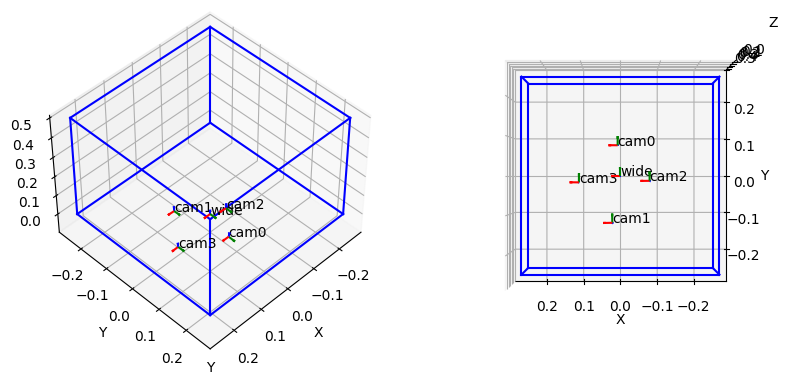

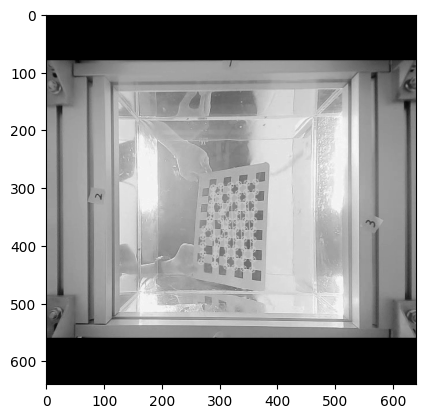

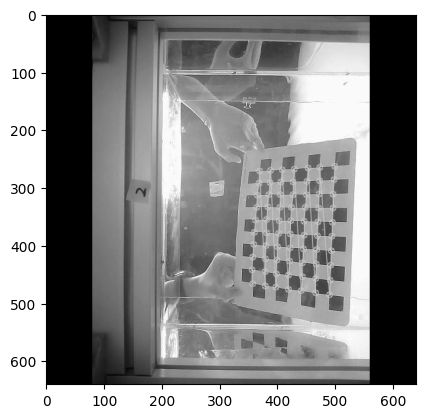

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.77561712e-04  6.84663533e-05 -5.86497355e-04]
 [ 5.55123425e-04  1.36932707e-04 -1.17299471e-03]
 [ 8.32685115e-04  2.05399054e-04 -1.75949202e-03]
 [ 1.11024685e-03  2.73865413e-04 -2.34598942e-03]
 [ 1.38780858e-03  3.42331772e-04 -2.93248682e-03]
 [ 1.66537023e-03  4.10798108e-04 -3.51898403e-03]
 [ 1.94293196e-03  4.79264467e-04 -4.10548143e-03]
 [ 2.22049370e-03  5.47730826e-04 -4.69197884e-03]
 [ 2.49805543e-03  6.16197185e-04 -5.27847624e-03]
 [-3.64626517e-04 -4.74182269e-04  5.30542654e-04]
 [-8.70648041e-05 -4.05715916e-04  1.11704001e-03]
 [ 1.90496908e-04 -3.37249563e-04  1.70353736e-03]
 [ 4.68058598e-04 -2.68783215e-04  2.29003467e-03]
 [ 7.45620333e-04 -2.00316856e-04 -1.08582783e-04]
 [ 1.02318207e-03 -1.31850497e-04 -3.46302948e-03]
 [ 1.30074371e-03 -6.33841608e-05 -4.04952669e-03]
 [ 1.57830545e-03  5.08219800e-06 -4.63602409e-03]
 [ 1.85586718e-03  7.35485568e-05 -5.22252149e-03]
 [ 2.13342892e-03  1.42014916e-

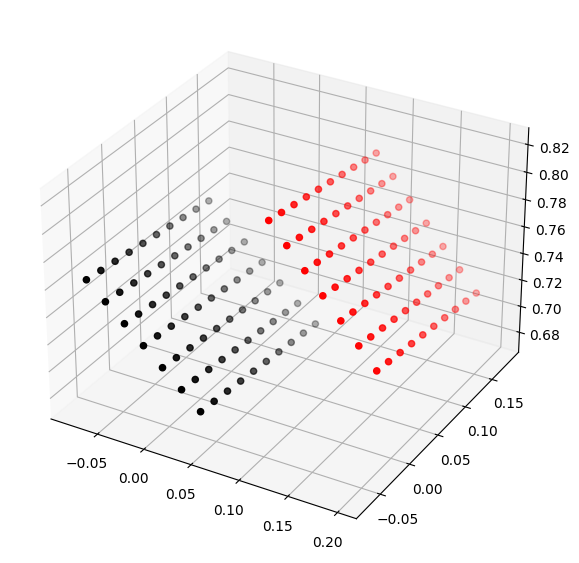

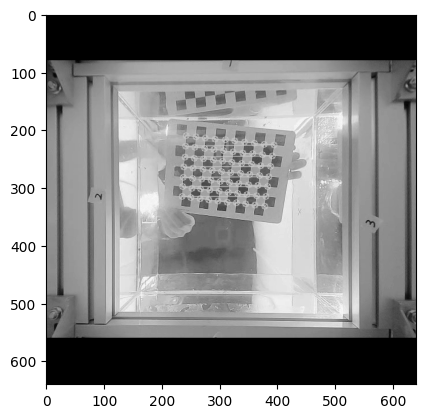

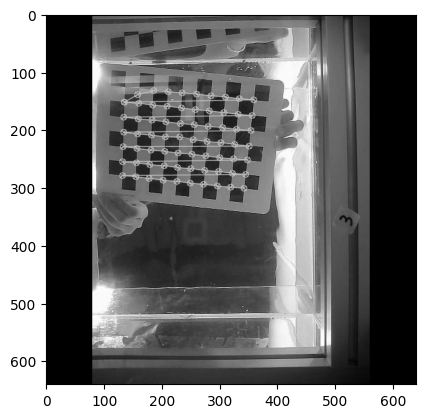

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.47423029e-04 -2.45207537e-04 -2.82442327e-03]
 [ 1.49484606e-03 -4.90415075e-04 -5.64884653e-03]
 [ 2.24226903e-03 -7.35622592e-04 -8.47326957e-03]
 [ 2.98969211e-03 -9.80830149e-04 -1.12976931e-02]
 [ 3.73711520e-03 -1.22603771e-03 -1.41221166e-02]
 [ 4.48453805e-03 -1.47124518e-03 -1.69465391e-02]
 [ 5.23196114e-03 -1.71645274e-03 -1.97709626e-02]
 [ 5.97938423e-03 -1.96166030e-03 -2.25953861e-02]
 [ 6.72680732e-03 -2.20686786e-03 -2.54198096e-02]
 [-4.88686705e-04 -4.91698301e-05  1.40306517e-03]
 [ 1.23610973e-03 -2.94377367e-04 -4.22748843e-03]
 [ 1.98353276e-03 -5.39584905e-04 -7.05191170e-03]
 [ 2.73095573e-03 -7.84792422e-04 -9.87633474e-03]
 [ 3.47837882e-03 -1.02999998e-03 -1.27007582e-02]
 [ 4.22580191e-03 -1.27520754e-03 -1.55251817e-02]
 [ 4.97322475e-03 -1.52041501e-03 -1.83496043e-02]
 [ 5.72064784e-03 -1.76562257e-03 -2.11740278e-02]
 [ 6.46807093e-03 -2.01083013e-03 -2.39984513e-02]
 [ 7.21549402e-03 -2.25603769e-

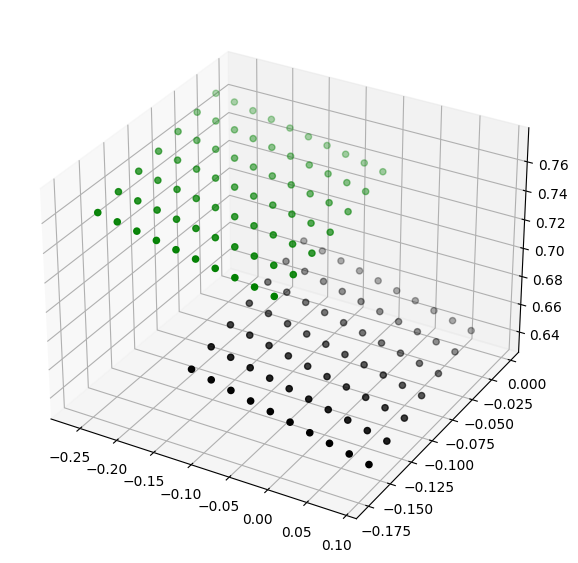

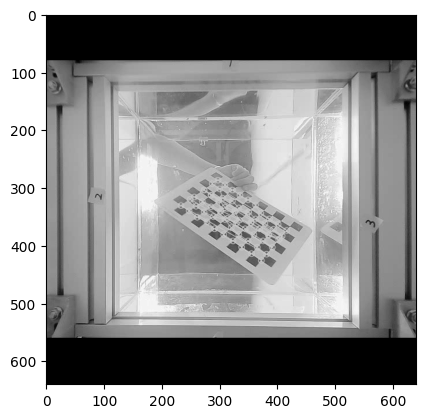

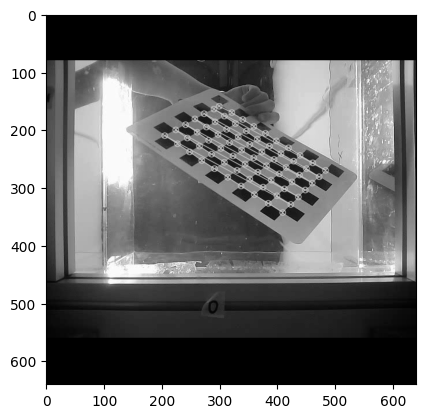

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.23208898e-04 -7.04955244e-05  1.38473909e-03]
 [-6.46417796e-04 -1.40991049e-04  2.76947818e-03]
 [-9.69626668e-04 -2.11486567e-04  4.15421716e-03]
 [-1.29283559e-03 -2.81982098e-04  5.53895637e-03]
 [-1.61604452e-03 -3.52477628e-04  6.92369557e-03]
 [-1.93925334e-03 -4.22973135e-04  8.30843433e-03]
 [-2.26246226e-03 -4.93468665e-04  9.69317353e-03]
 [-2.58567118e-03 -5.63964195e-04  1.10779127e-02]
 [-2.90888011e-03 -6.34459725e-04  1.24626519e-02]
 [ 1.77875164e-03  1.45434404e-03 -2.31271117e-03]
 [-2.10196054e-03  1.38384851e-03 -9.27972075e-04]
 [-2.42516944e-03  1.31335299e-03  4.56767017e-04]
 [-2.74837831e-03  1.24285747e-03  1.84150600e-03]
 [-3.07158723e-03  1.17236194e-03  3.22624520e-03]
 [-3.39479616e-03  1.10186641e-03  4.61098440e-03]
 [-3.71800498e-03  1.03137090e-03  5.99572316e-03]
 [-4.04121390e-03  9.60875371e-04  7.38046236e-03]
 [-4.36442283e-03  8.90379840e-04  8.76520157e-03]
 [-4.68763175e-03  8.19884310e-

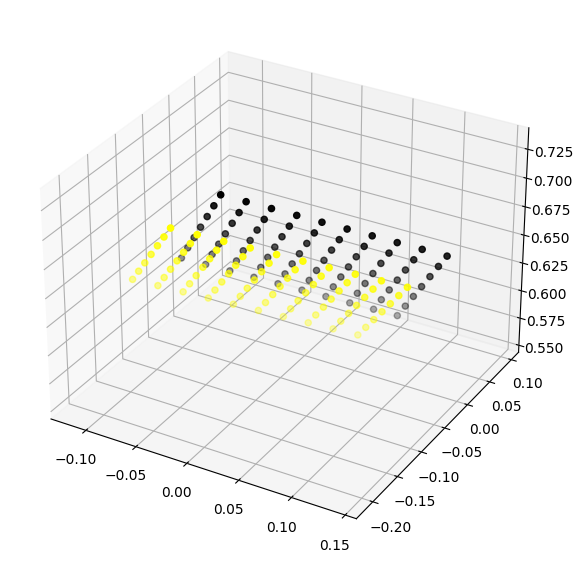

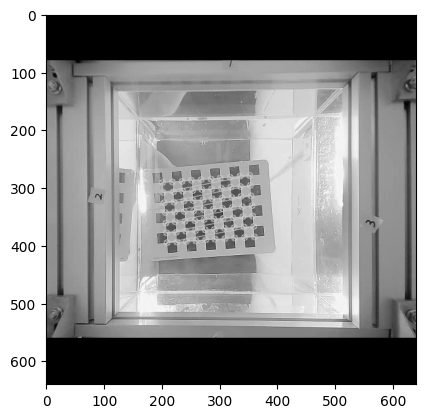

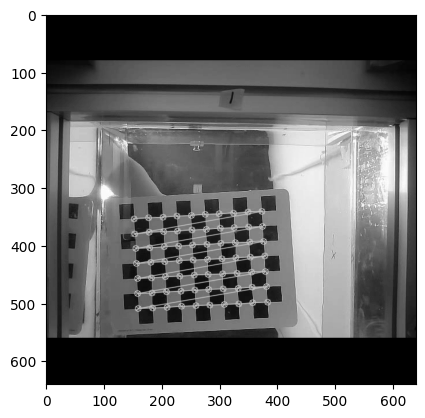

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.01369837e-04 -5.09662250e-04 -1.91030072e-03]
 [ 6.02739674e-04 -1.01932450e-03 -3.82060144e-03]
 [ 9.04109487e-04 -1.52898671e-03 -5.73090200e-03]
 [ 1.20547935e-03 -2.03864900e-03 -7.64120288e-03]
 [ 1.50684921e-03 -2.54831129e-03 -9.55150375e-03]
 [ 1.80821897e-03 -3.05797342e-03 -1.14618040e-02]
 [ 2.10958884e-03 -3.56763571e-03 -1.33721049e-02]
 [ 2.41095870e-03 -4.07729800e-03 -1.52824058e-02]
 [ 2.71232856e-03 -4.58696029e-03 -1.71927066e-02]
 [-3.35225660e-04 -3.74650228e-05  4.51776387e-04]
 [-3.38558232e-05  4.72197227e-04 -1.45852433e-03]
 [ 2.67514014e-04  9.81859477e-04 -3.36882505e-03]
 [ 5.68883827e-04  1.49152169e-03 -5.27912562e-03]
 [ 8.70253688e-04  2.00118398e-03 -7.18942649e-03]
 [ 1.17162355e-03  2.51084627e-03 -9.09972736e-03]
 [ 1.47299331e-03  3.02050839e-03 -1.10100276e-02]
 [ 1.77436317e-03  3.53017068e-03 -1.29203285e-02]
 [ 2.07573304e-03  4.03983298e-03 -1.48306294e-02]
 [ 2.37710290e-03  4.54949527e-

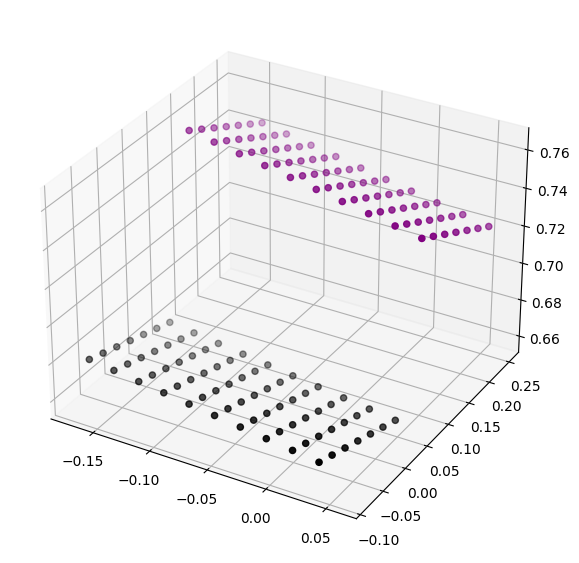

In [44]:
if os.path.exists('results/extrinsic_cam0.json') and os.path.exists('results/extrinsic_cam1.json') and os.path.exists('results/extrinsic_cam2.json') and os.path.exists('results/extrinsic_cam3.json') and os.path.exists('results/extrinsic_wide.json'):
    pass
else:
    extrinsic_calibration()

fig = plt.figure(figsize=(15, 10))
visualize(fig, 45, 0, 0, i=1)
visualize(fig, elev=45, azim=45, roll=0, i=1)
visualize(fig, elev=-90, azim=90, roll=0, i=2)
plt.show()
chessboard_projection()